In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import seaborn as sns
import string

import nltk
from nltk import word_tokenize
from nltk.tag import pos_tag, map_tag
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

/home/mbauw/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
# SW 1,2,4 en train
dfSW1_droid = pd.read_csv('trainReplicasSW1_droid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW1_nonDroid = pd.read_csv('trainReplicasSW1_nonDroid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW2_droid = pd.read_csv('trainReplicasSW2_droid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW2_nonDroid = pd.read_csv('trainReplicasSW2_nonDroid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW3_droid = pd.read_csv('trainReplicasSW3_droid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW3_nonDroid = pd.read_csv('trainReplicasSW3_nonDroid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW4_droid = pd.read_csv('trainReplicasSW4_droid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW4_nonDroid = pd.read_csv('trainReplicasSW4_nonDroid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW5_droid = pd.read_csv('trainReplicasSW5_droid.csv',sep='/',converters={"replica":str,"isDroid":int})
dfSW5_nonDroid = pd.read_csv('trainReplicasSW5_nonDroid.csv',sep='/',converters={"replica":str,"isDroid":int})

In [5]:
trainArray = [dfSW1_droid,dfSW1_nonDroid,dfSW2_droid,dfSW2_nonDroid,dfSW3_droid,dfSW3_nonDroid,dfSW4_droid,dfSW4_nonDroid,dfSW5_droid,dfSW5_nonDroid]
trainFrame = pd.concat(trainArray)

# Remove ponctuation (for postag and lemm. functions)

In [6]:
def getRidOfPunctuation(sentence):
    sentence = sentence.translate(str.maketrans('','', string.punctuation))
    return(sentence)

# Création d'une colonne des répliques lemmatized

In [7]:
wnl = WordNetLemmatizer()

def getLemmatizedSentenceFromRow(rawSentenceRow):
    rawSentence = rawSentenceRow['replica']
    lemmatizedList = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(rawSentence))]
    lemmatizedSentence = " ".join(lemmatizedList)
    return(getRidOfPunctuation(lemmatizedSentence))
    
def addLemmatizedSentencesColumnToDF(rawTextDF):
    rawTextDF['lemmatizedSentences'] = rawTextDF.apply(lambda row: getLemmatizedSentenceFromRow(row),axis=1)
    return(rawTextDF)

In [8]:
trainFrame
trainFrame = addLemmatizedSentencesColumnToDF(trainFrame)
trainFrame

,replica,isDroid,lemmatizedSentences
0,"I'm TC-14 at your service. This way, please.",1,I m TC14 at your service This way please
1,"We are greatly honored by your visit, Ambassad...",1,We be greatly honor by your visit Ambassadors...
2,Cease fire.,1,Cease fire
3,"Master Anakin, you are my maker and I wish you...",1,Master Anakin you be my maker and I wish you ...
4,"However, I should prefer it if I were a little...",1,However I should prefer it if I be a little m...
5,Sell me?,1,Sell me
6,My troops are in position to begin searching t...,1,My troop be in position to begin search the sw...
7,"Yes, sir.",1,Yes sir
8,"Captain, take them to Camp 4.",1,Captain take them to Camp 4
9,"Roger, roger.",1,Roger roger


# Création d'une colonne de POS Tag

https://stackoverflow.com/questions/5787673/python-nltk-how-to-tag-sentences-with-the-simplified-set-of-part-of-speech-tags

In [9]:
exampleSentence = dfSW1_droid['replica'][0]

text = nltk.word_tokenize(exampleSentence)
print(text)
posTagged = pos_tag(text)
simplifiedTags = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in posTagged]
type(simplifiedTags)

tagSentence = []
for posTag in simplifiedTags:
    tagSentence.append(posTag[1])
tagSentence = " ".join(tagSentence)
print(tagSentence)

['I', "'m", 'TC-14', 'at', 'your', 'service', '.', 'This', 'way', ',', 'please', '.']
PRON VERB ADJ ADP PRON NOUN . DET NOUN . NOUN .


In [10]:
def getPosTagSentenceFromRow(rawSentenceRow):
    rawSentence = rawSentenceRow['replica']
    tokenizedRaw = nltk.word_tokenize(rawSentence)
    posTaggedRaw = pos_tag(tokenizedRaw)
    simplifiedTags = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in posTaggedRaw]
    tagSentenceList = []
    for posTag in simplifiedTags:
        tagSentenceList.append(posTag[1])
    tagSentence = " ".join(tagSentenceList)
    return(getRidOfPunctuation(tagSentence))

def addPosTagSentencesColumnToDF(rawTextDF):
    rawTextDF['posTaggedSentences'] = rawTextDF.apply(lambda row: getPosTagSentenceFromRow(row),axis=1)
    return(rawTextDF)

In [11]:
trainFrame = addPosTagSentencesColumnToDF(trainFrame)
trainFrame

,replica,isDroid,lemmatizedSentences,posTaggedSentences
0,"I'm TC-14 at your service. This way, please.",1,I m TC14 at your service This way please,PRON VERB ADJ ADP PRON NOUN DET NOUN NOUN
1,"We are greatly honored by your visit, Ambassad...",1,We be greatly honor by your visit Ambassadors...,PRON VERB ADV VERB ADP PRON NOUN NOUN NOUN V...
2,Cease fire.,1,Cease fire,NOUN NOUN
3,"Master Anakin, you are my maker and I wish you...",1,Master Anakin you be my maker and I wish you ...,NOUN NOUN PRON VERB PRON NOUN CONJ PRON VERB ...
4,"However, I should prefer it if I were a little...",1,However I should prefer it if I be a little m...,ADV PRON VERB VERB PRON ADP PRON VERB DET ADJ...
5,Sell me?,1,Sell me,VERB PRON
6,My troops are in position to begin searching t...,1,My troop be in position to begin search the sw...,PRON NOUN VERB ADP NOUN PRT VERB VERB DET NOUN...
7,"Yes, sir.",1,Yes sir,X NOUN
8,"Captain, take them to Camp 4.",1,Captain take them to Camp 4,NOUN VERB PRON PRT NOUN NUM
9,"Roger, roger.",1,Roger roger,NOUN NOUN


# Création de la matrice de features répliques + posTagged répliques

In [12]:
tfidfRaw = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidfPosTags = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2))

features1 = tfidfRaw.fit_transform(trainFrame.lemmatizedSentences).toarray()
features2 = tfidfPosTags.fit_transform(trainFrame.posTaggedSentences).toarray()
labels = trainFrame.isDroid

print((features1 > 0.5).sum())
print((features2 > 0.5).sum())
print(type(features1))

print(features1.shape)
print(features2.shape)
features = np.concatenate((features1,features2),axis=1)
print(features.shape)

X_train = features
y_train = np.array(trainFrame['isDroid'])

257
163
<class 'numpy.ndarray'>
(424, 2059)
(424, 96)
(424, 2155)


# Show best part of each feature with Naive Bayes Classifier

In [13]:
clffeature1 = MultinomialNB().fit(features1, y_train)
clffeature2 = MultinomialNB().fit(features2, y_train)

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [14]:
show_most_informative_features(tfidfRaw,clffeature1,n=5)

	-7.8498	able near      		-5.6871	sir            
	-7.8498	aboard         		-5.7336	nt             
	-7.8498	aboard ship    		-5.8855	roger          
	-7.8498	academy        		-5.9933	r2             
	-7.8498	academy year   		-6.0703	oh             


In [15]:
show_most_informative_features(tfidfPosTags,clffeature2,n=5)

	-6.6287	adp prt        		-2.7375	noun           
	-6.6287	adv conj       		-2.8679	verb           
	-6.6287	conj adj       		-2.9400	pron           
	-6.6287	det prt        		-3.2386	pron verb      
	-6.6287	prt adv        		-3.3033	noun noun      


# Model selection

as suggested on https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [86]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(class_prior=[0.5,0.5]),
    LogisticRegression(random_state=0),
]

CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
      entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

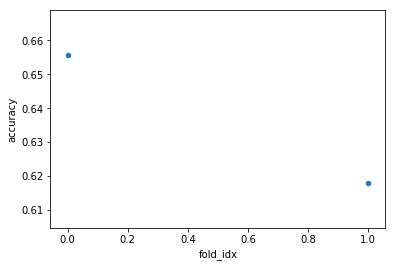

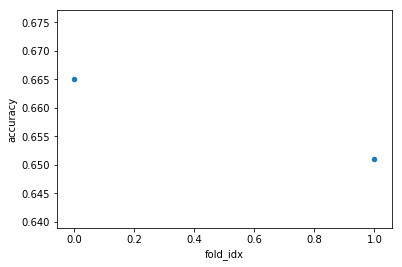

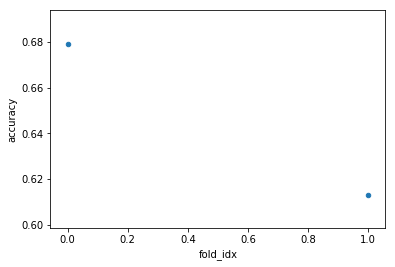

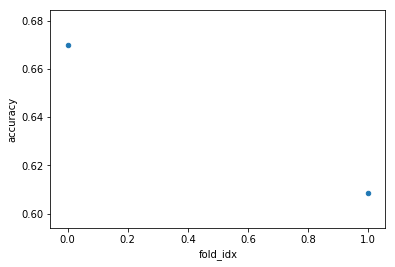

In [87]:
cv_df_RF = cv_df.loc[cv_df['model_name']=='RandomForestClassifier']
cv_df_RF.plot(x='fold_idx',y='accuracy',kind="scatter")

cv_df_LinearSVC = cv_df.loc[cv_df['model_name']=='LinearSVC']
cv_df_LinearSVC.plot(x='fold_idx',y='accuracy',kind="scatter")

cv_df_MultinomNB = cv_df.loc[cv_df['model_name']=='MultinomialNB']
cv_df_MultinomNB.plot(x='fold_idx',y='accuracy',kind="scatter")

cv_df_LogReg = cv_df.loc[cv_df['model_name']=='LogisticRegression']
cv_df_LogReg.plot(x='fold_idx',y='accuracy',kind="scatter")